# Exercise 1: t-SNE

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 

316492776
318900016

---
---


In [ ]:
# Required dependencies
!pip3 install numpy scipy pandas scikit-learn matplotlib mpl-tools tqdm seaborn

In [10]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from tqdm.auto import tqdm
import seaborn as sns

np.random.seed(42)

# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

tSNE is a non-linear dimensionality reduction algorithm, used mostly for the purpose of visualization in 2d and sometimes 3d.
Its input is $n$ points in a high dimentional space $\mathbb{R}^h$, and its output is $n$ correspoinding points in a $\mathbb{R}^2$.

The algorithm calculates pairwise similarity is the original space $p_{ij}$, and tries to make the similarities in the lower dimensional space $q_{ij}$ have the same distribution.
Its cost function is KL-divergence between P and Q distributions, which means higher $p_{ij}$ values are more important than smaller ones, meaning tSNE generally focuses on preserving local structure but will sometimes fail to capture global relationships.

tSNE is symetric (unlike regular SNE), and also uses t-distribution in the lower dimentional space in order to avoid shrinkage to a single point or a very dense cluster (since it has a heavy tail, unlike a gaussian which does not).

# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

We implement t-SNE as seen in the class, more specifically according to slides 61-66.
The calculation of $q_{ij}$ and $p_{ij}$ is pretty straight forward according to the theorey shown in class. We did, however, add one major improvement to make the algorithm converge in feasable time. Instead of calculating $p_{ij}$ for all $i \neq j$ pairs, we calculate it only for the $k$ closest neighbors (in the original space) of each point, since they contibute the most to the value of $C$, since if $X_i$ and $X_j$ are far apart, $p_{ij}$ will be closer to 0, and hence will not make much of a difference in the total summation of $C$.

Everything is done with vectorized code, to maximize efficiency and speed as much as possible.

By doing so, instead of calculating $N^2$ for each iteration for a total of $O(N^2 \cdot i)$ with $i$ being the number of iteration, we calculate only $O(N^2 + N \cdot k \cdot i)$, and with $k \ll N$ this makes a major difference.

The optimization is done by gradient descent process, with an option for early stopping if no progress is made after some time.

In [2]:
class CustomTSNE:
    def __init__(self, perplexity: float = 30.0, n_components: int = 2, n_iter: int = 1000, learning_rate: float = 200.0,
                 n_iter_without_progress: int = 3000, verbose: bool = True):
        self.perplexity = perplexity
        self.n_components = n_components
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        # Note: You may add more attributes
        self.sigma = 1  # TODO
        self.n_iter_without_progress = n_iter_without_progress
        self.verbose = verbose
        self.min_iter = n_iter // 10

    def fit_transform(self, X):
        # Part 1: Implementing t-SNE

        # Step 1: Compute pairwise affinities in the original space with a Gaussian distribution
        # Your code here
        X = X/np.max(X)
        N = len(X)
        n_neighbors = min(N-1, 3*int(self.perplexity))
        X_dists = squareform(pdist(X))
        n_nearest_indexes = np.argsort(X_dists, axis=1)[:, 1:n_neighbors+1]
        # +1 to remove i=j
        X_dists = np.take_along_axis(X_dists, n_nearest_indexes, axis=1)
        p_ij = self.calc_pij(X_dists)

        Y = np.random.random((N, self.n_components))

        best_i, best_C = -1, np.inf
        for i in tqdm(range(self.n_iter), disable=not self.verbose, desc="iteration"):
            Y_diff = Y[:, np.newaxis, :] - Y[n_nearest_indexes]
            Y_dists = np.linalg.norm(Y_diff, axis=-1)
            Y_dists = 1+Y_dists**2
            Y_dists = Y_dists ** -1
            q_ij = Y_dists / np.sum(Y_dists)  # normalize to a probabilty

            C = p_ij * np.log(p_ij/q_ij)
            C = np.sum(C)
            if self.verbose:
                print(f"After {i} iterations, {C=}")
            if C < best_C:
                best_i, best_C = i, C
            if self.min_iter < i and best_i + self.n_iter_without_progress < i:
                if self.verbose:
                    print(
                        f"C has not improved for {self.n_iter_without_progress} steps. Stopping early.")
                return Y

            grad_C_yi = 4 * \
                np.sum((p_ij - q_ij)[..., np.newaxis] *
                       Y_diff * Y_dists[..., np.newaxis], axis=1)

            # Return Y, the 2D representation of the input data
            Y -= self.learning_rate * grad_C_yi
        if self.verbose:
            print(f"{C=} after {self.n_iter} iterations")
        return Y

    # Part 2: Transformation of New Data Points
    def transform(self, X_original, Y_original, X_new):
        N = len(X_new)
        n_neighbors = min(N-1, 3*int(self.perplexity))
        Y_new = []

        # Added weights to the distances as following: [1, 1/2, 1/3, 1/4.... 1/n]
        # The minimal distance get's the highest weight, and the weight is reduced as the distance increasing
        W_arr = np.arange(1, n_neighbors + 1, dtype=float) ** -1

        # Calculate the distance array for each one of the test values
        dists = cdist(X_new, X_original)

        # Sort the indices of the distances from minimal to maximal while limit just to the n_neighbors distances
        n_nearest_indexes = np.argsort(dists, axis=1)[:, :n_neighbors]

        # Find the average location based on the indices of the distances, while the distances are weighted (Minimal distance -> max weight)
        Y_new = np.average(
            Y_original[n_nearest_indexes], weights=W_arr, axis=1)

        return np.array(Y_new)

    def calc_pij(self, X_dists, min_sigma: float = 1e-3, max_sigma: float = 1e+3):
        N = len(X_dists)
        min_sigma = np.ones((N, 1))*min_sigma
        max_sigma = np.ones((N, 1))*max_sigma
        for i in tqdm(range(30), disable=not self.verbose, desc="finding sigma"):
            curr_sigma = (min_sigma + max_sigma)/2
            p_ij = -X_dists**2 / (2*curr_sigma**2)
            # for numeric stability
            p_ij -= p_ij.max(axis=1, keepdims=True)
            p_ij = np.exp(p_ij)
            # normalize to a probabilty
            p_ij = p_ij / p_ij.sum(axis=1, keepdims=True)
            distribution_entropy = (-p_ij * np.log2(p_ij)
                                    ).sum(axis=1, keepdims=True)
            distribution_perplexity = 2**distribution_entropy
            min_sigma, max_sigma = (
                np.where(distribution_perplexity <
                         self.perplexity, curr_sigma, min_sigma),
                np.where(distribution_perplexity >
                         self.perplexity, curr_sigma, max_sigma)
            )

        return p_ij / p_ij.sum()

# Load data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

We chose to use MNIST dataset to our algorithm.
MNIST is a very popular yet simple dataset, which is used wordlwide for basic/begginer ML tasks, and has many examples specifically for dimensionality reduction outputs (PCA and tSNE). This will allow us to compare ourself. 
It's usage is about encoding a digit in an image (Assuming the digit is shown as pixels just like one takes a photo of a car plate), and each image is labeled by it's digit value

Using T-SNE algorithm, we can find the relationship and the distances between the images with a very clear and visual way, while since we have just 10 digits in MNIST (0-9), we can classify the images into 10 groups and show in 2D dimension the relationship and distance between them

We split the dataset into train (80%) and test (20%) while the dataset contains 10,000 examples in total

Since the image values are described by grayscale pixel codes (0 -> white to 255 -> black), the digits should be represented as black while the background as white, but in fact the digits are in various range of colors between white and black (gray, dark gray. etc). Then, in order to reduce errors since the colors distribution, we want to normalize it so the digit will be represented with one single pixel code

In [3]:
# Loading the data into train / test datasets

dataset = pd.read_csv("./Dataset/mnist_dataset.csv")

# The X axis is the pixels grayscale matrix that represents the digit
X = dataset.loc[:,'1x1':].values

# The y axis is the actual digit that the the pixels matrix represents
y = dataset.loc[:,'label'].values

X_train, X_test, label_train, label_test = train_test_split(
    X, y, test_size=0.2)

# Normalizing the grayscale codes by dividing it to the max grayscale value.
X_train_normalized_opt1 = X_train / 255
X_test_normalized_opt1 = X_test / 255

# Normalizing the grayscale codes by standard scaler
sc = StandardScaler()
X_train_normalized_opt2 = sc.fit_transform(X_train)
X_test_normalized_opt2 = sc.transform(X_test)

In [4]:
dataset.head()

label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      7    0    0    0    0    0    0    0    0    0  ...      0      0   
1      2    0    0    0    0    0    0    0    0    0  ...      0      0   
2      1    0    0    0    0    0    0    0    0    0  ...      0      0   
3      0    0    0    0    0    0    0    0    0    0  ...      0      0   
4      4    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]

In [5]:
X_train.shape

(8000, 784)

In [6]:
X_train_normalized_opt1.shape

(8000, 784)

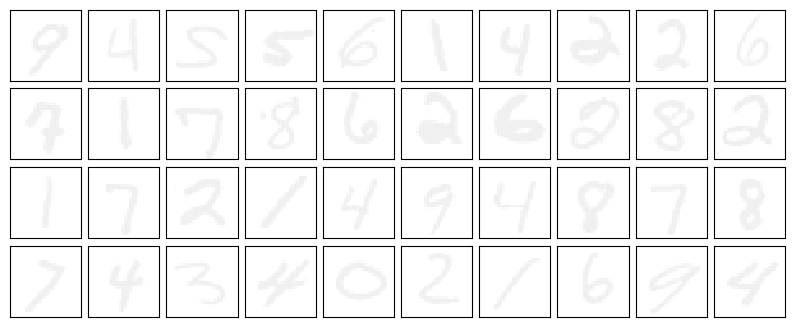

In [7]:
# This is a ploting of sample train data

fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_normalized_opt1[i].reshape(28, 28),
              cmap='binary', interpolation='nearest',
              clim=(0, 16))

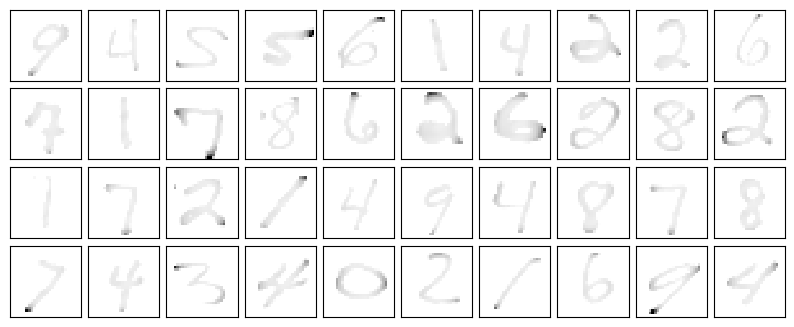

In [220]:
# This is a ploting of sample train data

fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_normalized_opt2[i].reshape(28, 28),
              cmap='binary', interpolation='nearest',
              clim=(0, 16))

# t-SNE demonstration 
Demonstrate your t-SNE implementation.

Add plots and figures. The code below is just to help you get started, and should not be your final submission.

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

As we can see below, we've tested the module with a various combination of Hypher-Parameters

The most important hypher-param is the perplexity. We found that a large number of perplexity causes a very dense and unified groups of digits but with some little mistakes since with high perplexity we can also "catch" neighbors that represents another disits. However, with a low number of perplexity the observabilities will not be unified and scattered along the graph
Therefore, according to our research the optimal perplexity number is something about 15-30

Regarding learning rate, higher learning rate causes the group be closer to each other, and smaller learning rate makes the groups be more far away, since the Y output values are getting more centralized with higher learning rate value. The optimal learning rate is about 100-200. However, it has less affect on the results than the perplexity

Redarding the number of iterations, we've tested with 1000 and 500 iterations and didn't find meaningful changes. However a large number of iterations can cause overfitting


In [ ]:
hypher_pharams_options = [{
    'n_components': 2,
    'n_iter': 1000,
    'perplexity': 100,
    'learning_rate': 200
},{
    'n_components': 2,
    'n_iter': 1000,
    'perplexity': 50,
    'learning_rate': 200
},{
    'n_components': 2,
    'n_iter': 500,
    'perplexity': 30,
    'learning_rate': 100
},{
    'n_components': 2,
    'n_iter': 1000,
    'perplexity': 15,
    'learning_rate': 100
},{
    'n_components': 2,
    'n_iter': 1000,
    'perplexity': 15,
    'learning_rate': 50
},
{
    'n_components': 2,
    'n_iter': 1000,
    'perplexity': 5,
    'learning_rate': 50
},
{
    'n_components': 2,
    'n_iter': 1000,
    'perplexity': 50,
    'learning_rate': 200
},{
    'n_components': 3,
    'n_iter': 1000,
    'perplexity': 20,
    'learning_rate': 200
}]

hypher_pharams_options_test = [{
    'n_components': 2,
    'n_iter': 1000,
    'perplexity': 50,
    'learning_rate': 200
}]

results_array = []

for hypher_params in hypher_pharams_options:
    n_components = hypher_params["n_components"]
    n_iter = hypher_params["n_iter"]
    perplexity = hypher_params["perplexity"]
    learning_rate = hypher_params["learning_rate"]
    print(f"Running with number of components {n_components}, number of iterations {n_iter}, perplexity {perplexity} and lr {learning_rate}")
    
    # Run your custom t-SNE implementation
    custom_tsne = CustomTSNE(n_components=n_components, n_iter=n_iter, perplexity=perplexity, learning_rate=learning_rate)
    custom_Y = custom_tsne.fit_transform(X_train_normalized_opt1)
    
    # Run sklearn t-SNE
    sk_tsne = TSNE(n_components=n_components, init='random', perplexity=perplexity)
    sk_Y = sk_tsne.fit_transform(X_train_normalized_opt1)
    
    results_array.append({'custom_Y': custom_Y, 'sk_Y': sk_Y, 'dbscan_clusters': dbscan_clusters})

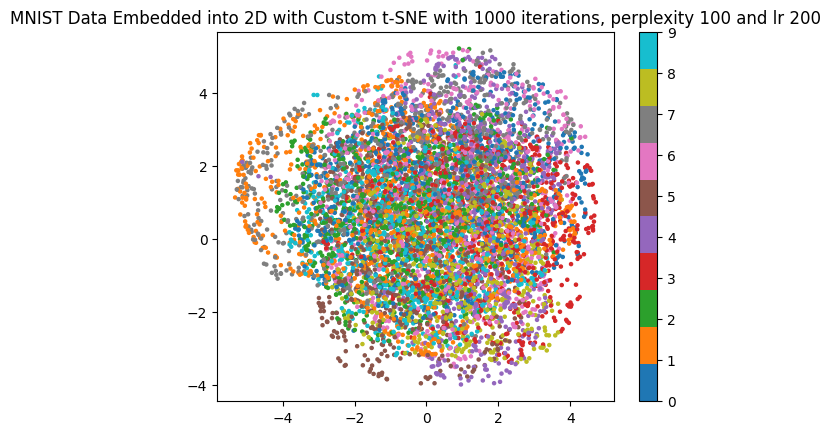

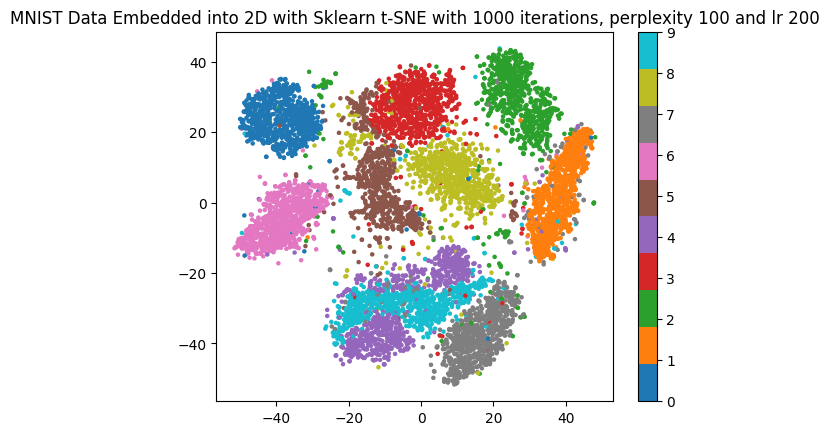

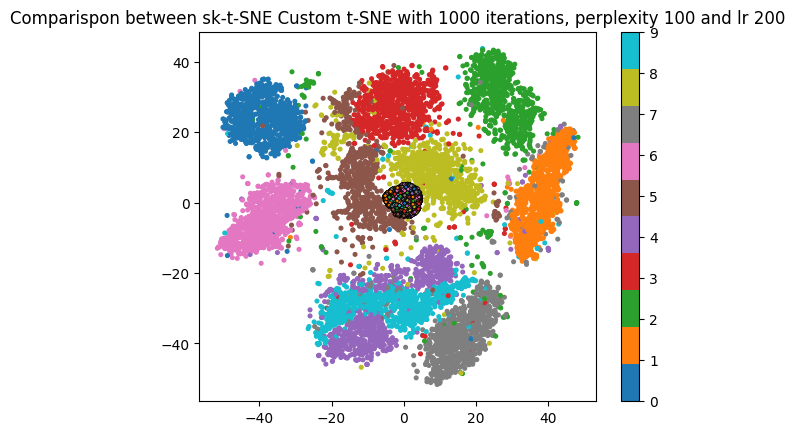

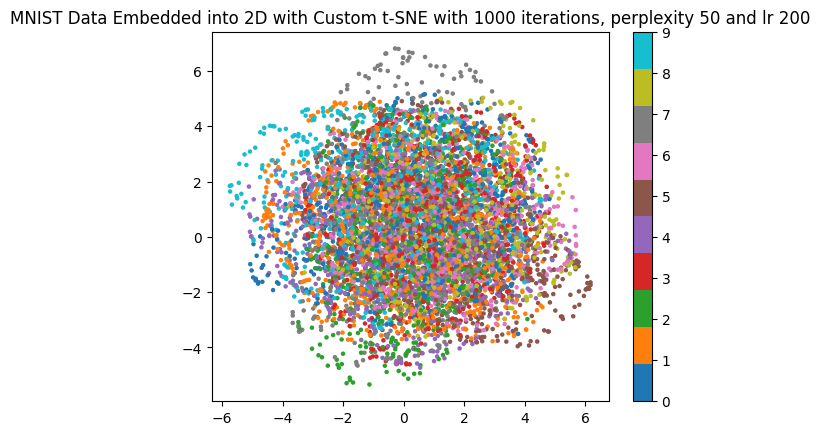

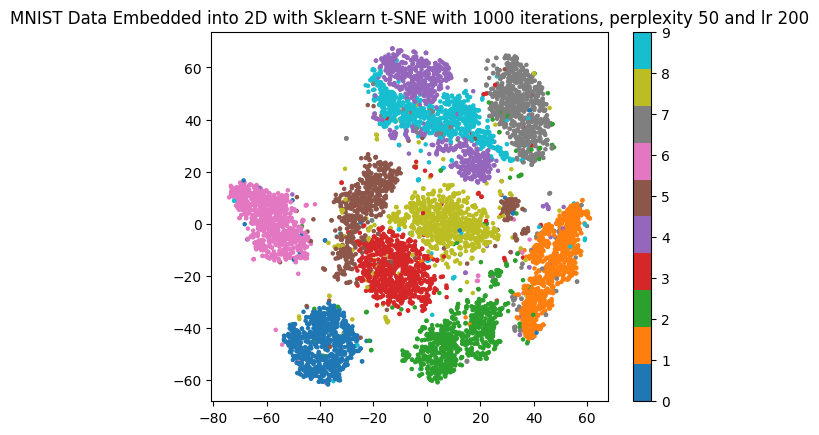

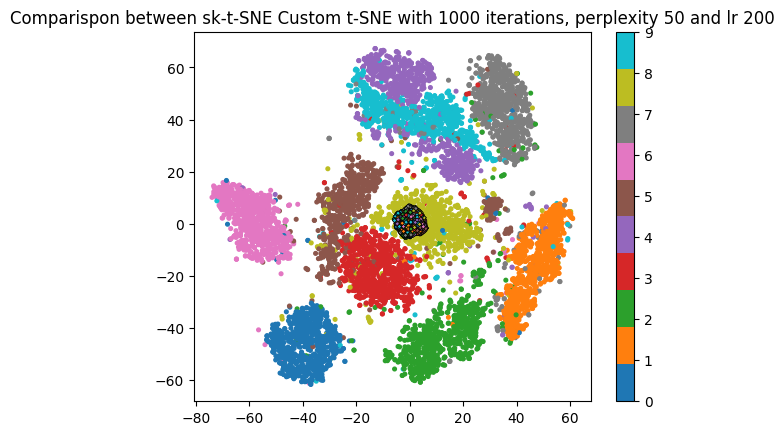

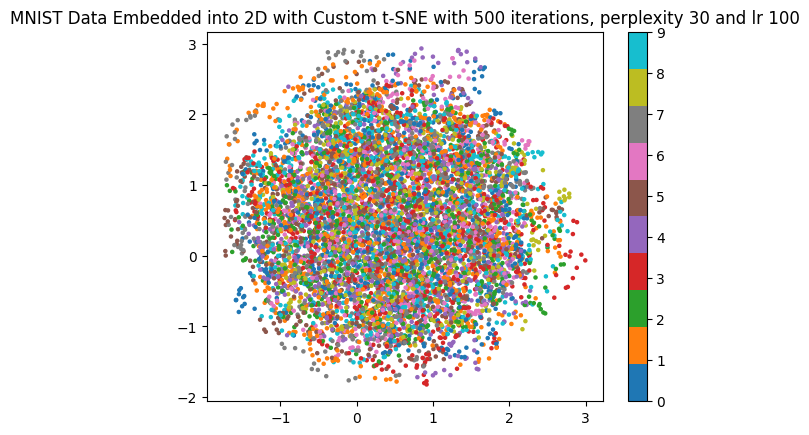

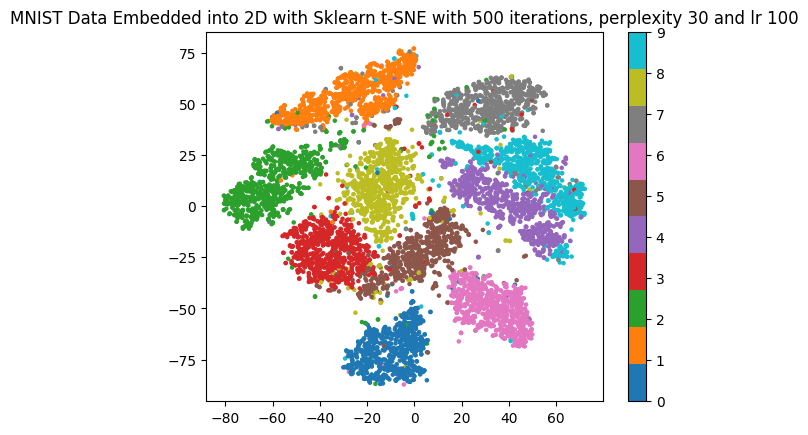

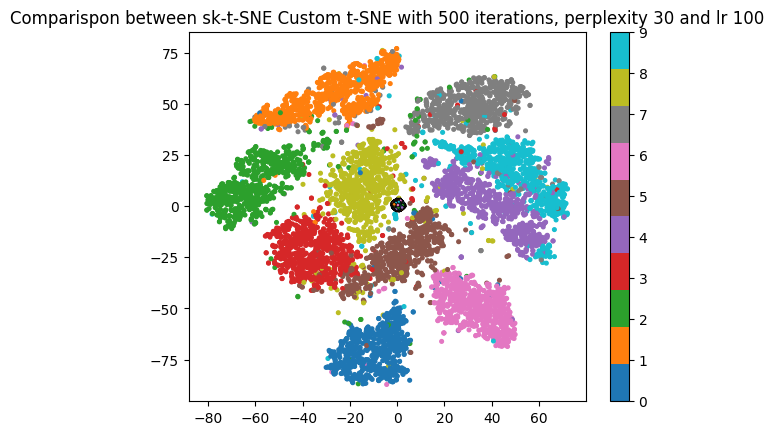

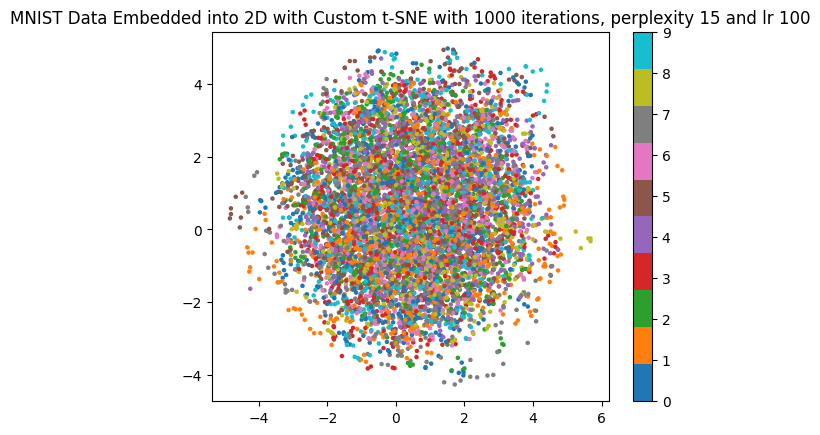

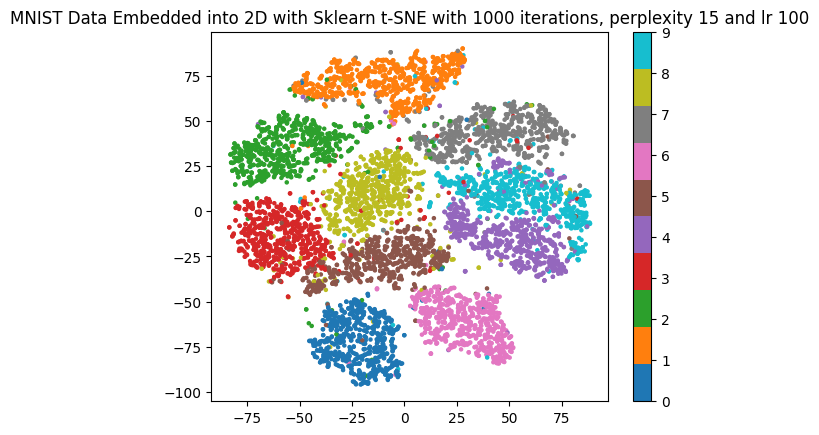

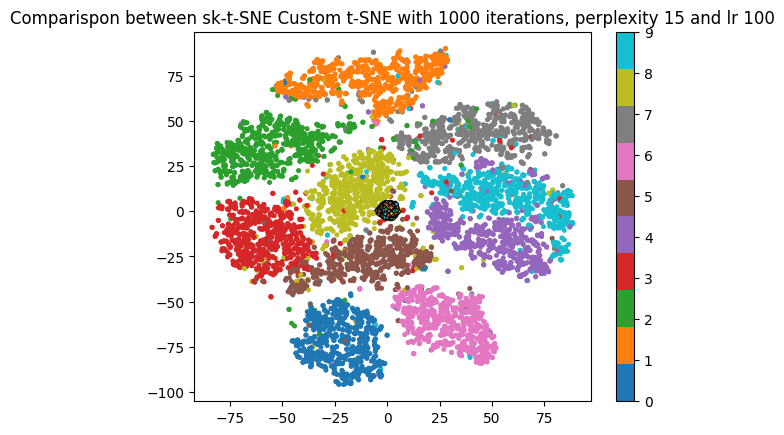

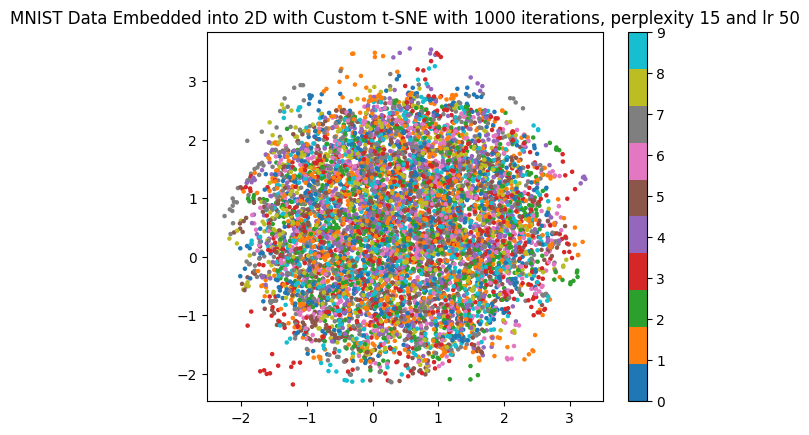

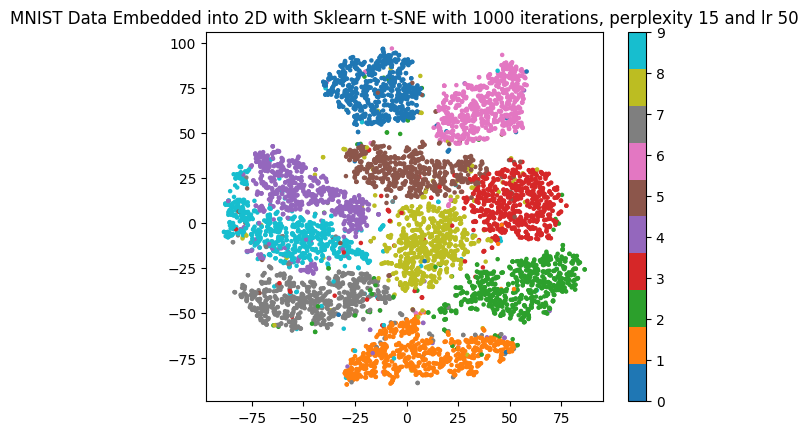

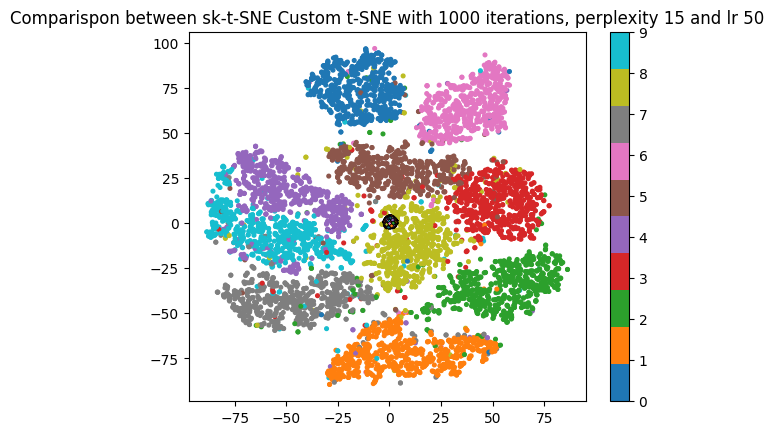

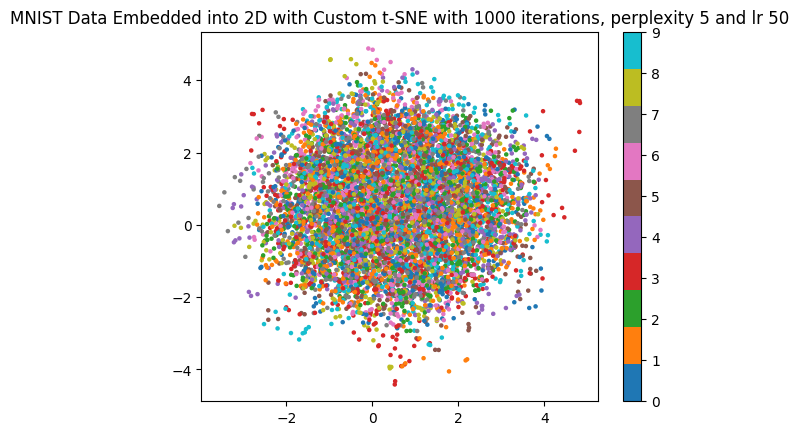

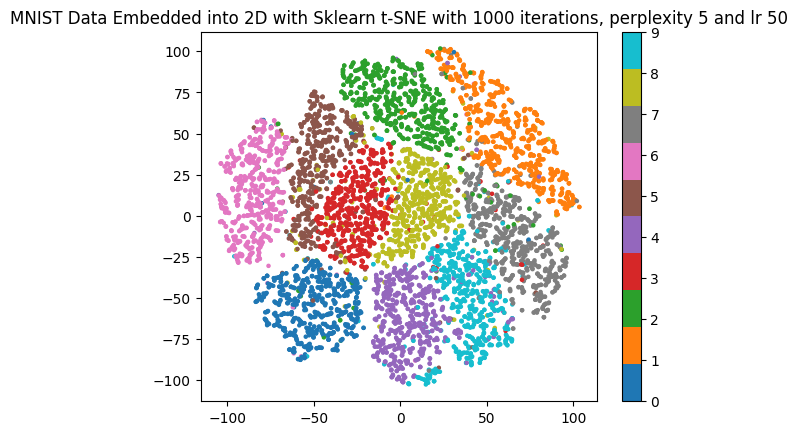

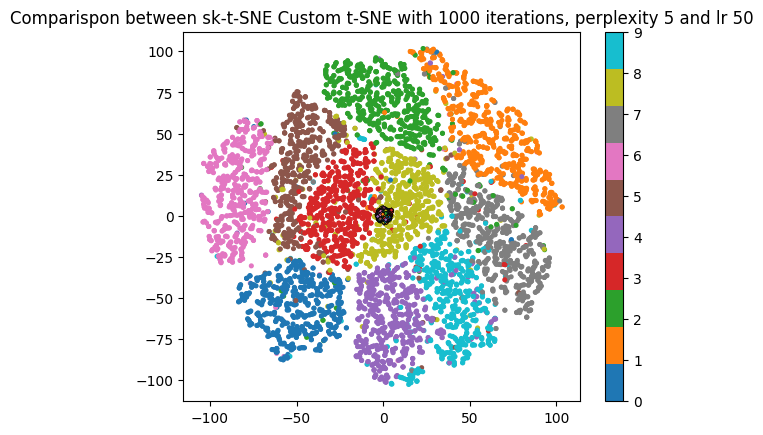

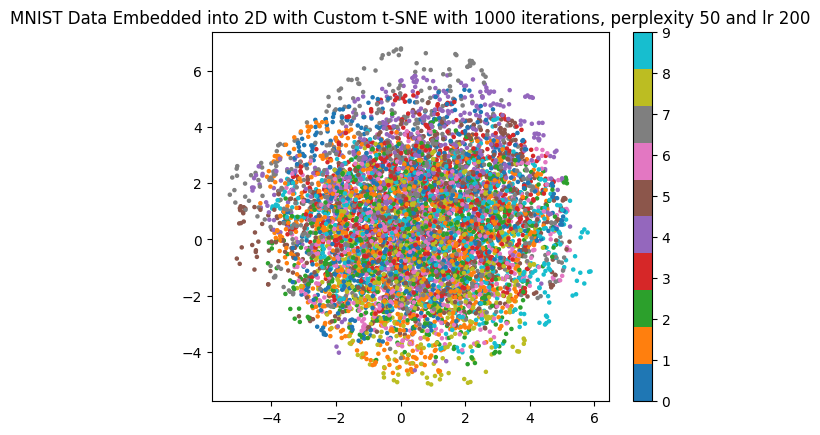

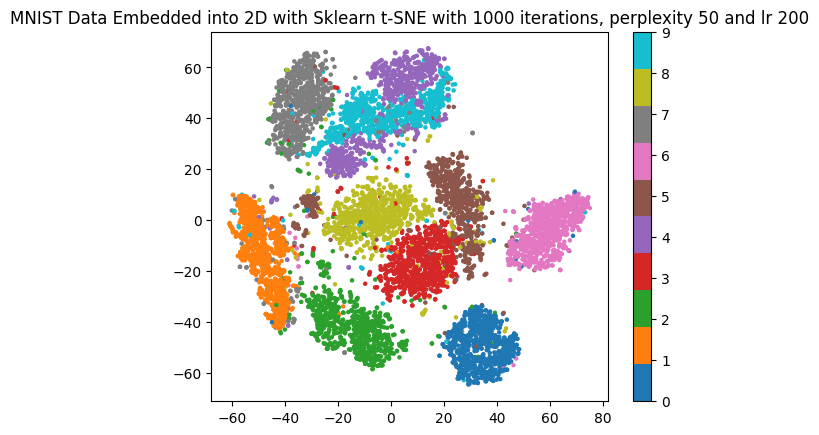

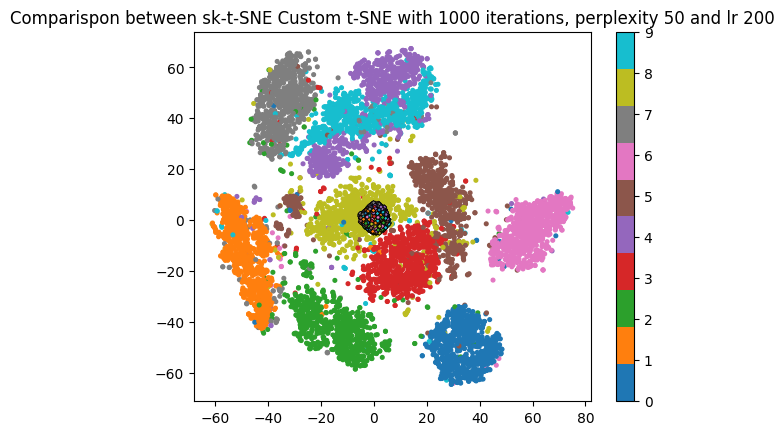

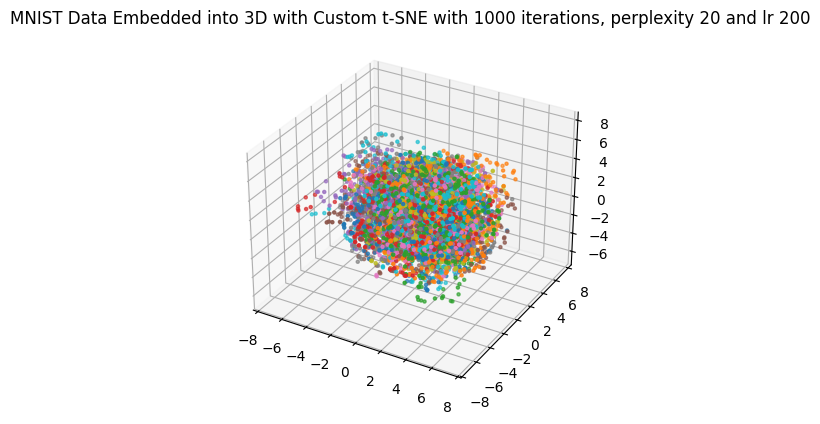

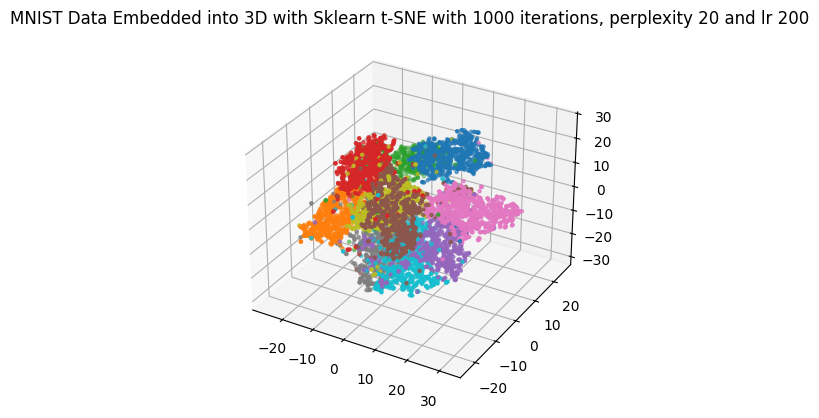

In [60]:
for idx, result in enumerate(results_array):
    if result["sk_Y"].shape[1] == 2:
        # Visualization of the result
        plt.figure()
        plt.scatter(result["custom_Y"][:, 0], result["custom_Y"][:, 1], s=5, c=label_train.astype(int), cmap='tab10')
        plt.colorbar()
        plt.title(f"MNIST Data Embedded into 2D with Custom t-SNE with {hypher_pharams_options[idx]['n_iter']} iterations, perplexity {hypher_pharams_options[idx]['perplexity']} and lr {hypher_pharams_options[idx]['learning_rate']}")
        plt.show()
        
        plt.figure()
        plt.scatter(result["sk_Y"][:, 0], result["sk_Y"][:, 1], s=5, c=label_train.astype(int), cmap='tab10')
        plt.colorbar()
        plt.title(f"MNIST Data Embedded into 2D with Sklearn t-SNE with {hypher_pharams_options[idx]['n_iter']} iterations, perplexity {hypher_pharams_options[idx]['perplexity']} and lr {hypher_pharams_options[idx]['learning_rate']}")
        plt.show()

        plt.figure()
        plt.scatter(result["sk_Y"][:, 0], result["sk_Y"][:, 1], s=7, c=label_train.astype(int), cmap='tab10')
        plt.scatter(result["custom_Y"][:, 0], result["custom_Y"][:, 1], marker = 'D', s=5, linewidth=0.5, edgecolors='k', c=label_train.astype(int), cmap='tab10')
        plt.colorbar()
        plt.title(f"Comparispon between sk-t-SNE Custom t-SNE with {hypher_pharams_options[idx]['n_iter']} iterations, perplexity {hypher_pharams_options[idx]['perplexity']} and lr {hypher_pharams_options[idx]['learning_rate']}")
        plt.show()
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(result["custom_Y"][:, 0], result["custom_Y"][:, 1], result["custom_Y"][:, 2], s= 5, c=label_train, cmap='tab10')
        plt.title(f"MNIST Data Embedded into 3D with Custom t-SNE with {hypher_pharams_options[idx]['n_iter']} iterations, perplexity {hypher_pharams_options[idx]['perplexity']} and lr {hypher_pharams_options[idx]['learning_rate']}")
        plt.show()
        plt.show()
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(result["sk_Y"][:, 0], result["sk_Y"][:, 1], result["sk_Y"][:, 2], s= 5, c=label_train, cmap='tab10')
        plt.title(f"MNIST Data Embedded into 3D with Sklearn t-SNE with {hypher_pharams_options[idx]['n_iter']} iterations, perplexity {hypher_pharams_options[idx]['perplexity']} and lr {hypher_pharams_options[idx]['learning_rate']}")
        plt.show()
        plt.show()

# t-SNE extension - mapping new samples
Demonstrate your t-SNE transformation procedure.

Add plots and figures.

Please use the cell below t describe your suggested approach in detail. Use formal notations where appropriate.
Describe and discuss your results.

We chose to use the transfort method as following:
1. For each one of the test set observabilities, we've calculated the distance from it's grayscale vector to any of the grayscale vectors in the train set
2. We find the top n nearest vectors (While n is the perplexity used in the fit_transofrm method) and we build a new matrix of (n X 2) that contains the original Y values of the n nearest vectors from the train set, sorted from 1st nearest to n nearest (Each Y value contains 2 values, the x axis and the y axis in the target 2D graph)
3. The target Y value of the test grayscale vector is the weighted average of the Y values of the n nearest vectors from the train set. While the weight of each value is $\frac{1}{i}, 1 \leq i \leq n$ (The nearest value is weighted by $1$, the 2nd by $\frac{1}{2}$, the 3rd by $\frac{1}{3}$, and the n by $\frac{1}{n}$)
4. We repeat this for each one of the test values, until we build a final Y vector of (Test_Size X 2) of 2D values to be in the graph

The reason we compare the distances between the grayscale vectors of each one of the test examples to the train examples, is the assumption that each digit represented by a pixel code is not exactly the same as other pixel code vectors of the same digit, but the distance is minimal to grayscale vectors represents the same digit.
Then we assume that most of the n grayscale nearest vectors represents the same digit as the test sample
Then we want to locate it around the n grayscale nearest vectors but with more weight to the closest vector and less weight as the vector is getting less close

With that approach we set the Y vectors of the test samples around the group of their digits

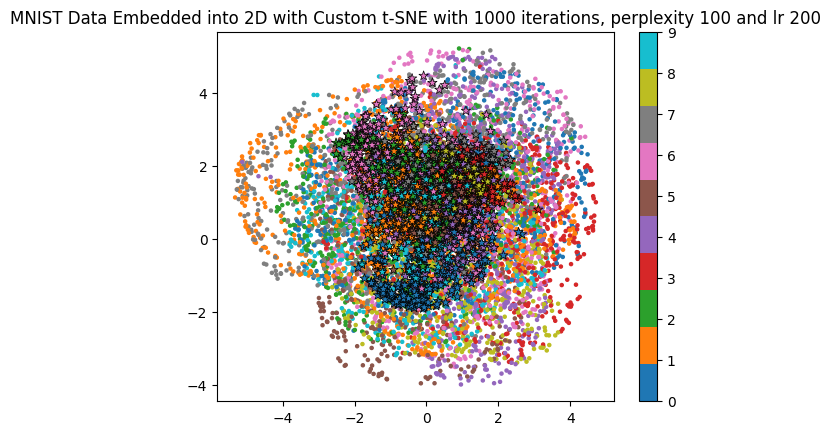

10 Closests train actual digits for each test digit


actual digit  1 closest digit  2 closest digit  3 closest digit  \
0              6                2                8                1   
1              2                8                2                7   
2              3                3                0                7   
3              7                4                4                5   
4              2                9                1                1   
5              2                8                1                2   
6              3                3                2                7   
7              4                0                6                0   
8              7                4                2                4   
9              6                5                2                2   
10             6                3                5                6   
11             9                0                9                3   
12             2                2                0                8   
13             0                5                5                2   
14             9                8                3                0   
15             6                0                7                4   
16             8                2                4                2   
17             0                9                9                9   
18             6                7                2                7   
19             5                7                5                7   
20             1                5                3                1   
21             4                8                6                4   
22             8                0                7                7   
23             1                8                5                0   
24             9                1                6                8   
25             8                3                9                2   
26             4                8                0                6   
27             0                5                6                6   
28             0                3                9                8   
29             5                1                6                1   
30             2                3                5                6   
31             4                5                9                7   
32             2                0                0                9   
33             1                2                7                6   
34             3                7                0                4   
35             2                7                0                9   
36             8                2                7                9   
37             1                4                7                2   
38             7                0                2                2   
39             6                2                1                9   
40             8                5                9                1   
41             2                5                3                5   
42             3                5                1                3   
43             3                2                0                3   
44             6                0                4                7   
45             1                3                8                0   
46             0                2                1                9   
47             4                1                1                0   
48             1                9                0                0   
49             0                9                0                3   

    4 closest digit  5 closest digit  6 closest digit  7 closest digit  \
0                 9                7                2                7   
1                 3                9                3                8   
2                 0                0                5                9   
3                 9                5                8                7   
4           

10 Closests train distances for each test oservability


actual digit  1 closest distance  2 closest distance  3 closest distance  \
0              6            0.055703            0.085642            0.126275   
1              2            0.041397            0.043403            0.055757   
2              3            0.005775            0.024779            0.037006   
3              7            0.037319            0.051210            0.082987   
4              2            0.054975            0.055609            0.061741   
5              2            0.020452            0.067368            0.073646   
6              3            0.007286            0.032954            0.036629   
7              4            0.019399            0.043994            0.060039   
8              7            0.020199            0.030057            0.046547   
9              6            0.021874            0.034212            0.045636   
10             6            0.039679            0.081511            0.082363   
11             9            0.007082            0.009167            0.017007   
12             2            0.023932            0.051845            0.071516   
13             0            0.060593            0.062246            0.083478   
14             9            0.012099            0.049807            0.055547   
15             6            0.051052            0.058977            0.063394   
16             8            0.018717            0.032150            0.041717   
17             0            0.035293            0.036524            0.047324   
18             6            0.057371            0.069225            0.076594   
19             5            0.038687            0.048830            0.085059   
20             1            0.028048            0.038367            0.046115   
21             4            0.035716            0.043755            0.047135   
22             8            0.015686            0.024392            0.049419   
23             1            0.029787            0.047978            0.057339   
24             9            0.030260            0.062196            0.064117   
25             8            0.032494            0.044675            0.059032   
26             4            0.035142            0.049569            0.053969   
27             0            0.032191            0.073423            0.073622   
28             0            0.023299            0.052419            0.061881   
29             5            0.035139            0.037456            0.061569   
30             2            0.014645            0.030796            0.048324   
31             4            0.059838            0.065062            0.068058   
32             2            0.019362            0.046987            0.059803   
33             1            0.068089            0.075479            0.089365   
34             3            0.040904            0.064022            0.093875   
35             2            0.022871            0.049668            0.059056   
36             8            0.032740            0.046162            0.065100   
37             1            0.032650            0.044087            0.062637   
38             7            0.012804            0.014506            0.016311   
39             6            0.015132            0.090708            0.111875   
40             8            0.028494            0.041076            0.054210   
41             2            0.024445            0.025261            0.055356   
42             3            0.039529            0.044931            0.057603   
43             3            0.034762            0.075370            0.094546   
44             6            0.022551            0.034068            0.038212   
45             1            0.013417            0.030319            0.033993   
46             0            0.050950            0.059269            0.060039   
47             4            0.032520            0.039564            0.054424   
48             1            0.029463            0.056447            0.066006   
49  

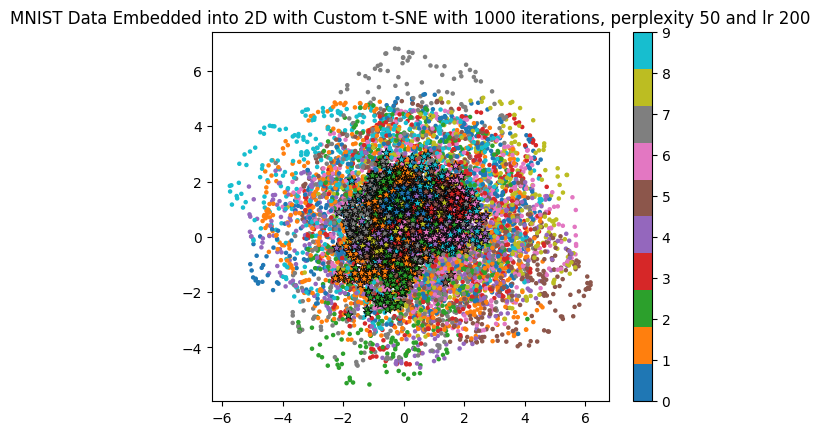

10 Closests train actual digits for each test digit


actual digit  1 closest digit  2 closest digit  3 closest digit  \
0              6                6                6                5   
1              2                2                2                0   
2              3                1                4                5   
3              7                5                2                9   
4              2                5                8                3   
5              2                6                0                9   
6              3                6                1                4   
7              4                2                9                0   
8              7                3                3                7   
9              6                8                4                1   
10             6                4                3                3   
11             9                6                9                8   
12             2                8                7                2   
13             0                8                8                6   
14             9                8                1                5   
15             6                2                6                7   
16             8                7                2                4   
17             0                5                7                4   
18             6                2                2                8   
19             5                9                2                6   
20             1                9                2                0   
21             4                0                2                7   
22             8                8                6                5   
23             1                8                8                6   
24             9                9                3                9   
25             8                3                3                9   
26             4                6                2                9   
27             0                6                6                9   
28             0                4                5                1   
29             5                2                1                7   
30             2                0                9                4   
31             4                4                3                2   
32             2                7                3                6   
33             1                4                8                9   
34             3                0                5                0   
35             2                5                5                9   
36             8                6                9                4   
37             1                0                7                3   
38             7                9                9                0   
39             6                6                4                9   
40             8                7                5                3   
41             2                0                4                1   
42             3                2                3                0   
43             3                9                4                6   
44             6                8                6                1   
45             1                0                1                4   
46             0                5                4                7   
47             4                9                5                5   
48             1                9                9                9   
49             0                2                1                2   

    4 closest digit  5 closest digit  6 closest digit  7 closest digit  \
0                 8                6                5                6   
1                 2                0                1                0   
2                 8                3                6                7   
3                 4                0                5                2   
4           

10 Closests train distances for each test oservability


actual digit  1 closest distance  2 closest distance  3 closest distance  \
0              6            0.048793            0.070565            0.071949   
1              2            0.031058            0.066612            0.067963   
2              3            0.011622            0.046797            0.071433   
3              7            0.044742            0.063289            0.087265   
4              2            0.066498            0.075982            0.106666   
5              2            0.060902            0.068704            0.072119   
6              3            0.061181            0.084168            0.096663   
7              4            0.049714            0.065782            0.070772   
8              7            0.034429            0.045062            0.058173   
9              6            0.006232            0.017645            0.087687   
10             6            0.034423            0.062543            0.078966   
11             9            0.025191            0.030774            0.041246   
12             2            0.067789            0.071625            0.076019   
13             0            0.012724            0.034494            0.040393   
14             9            0.054358            0.068447            0.088478   
15             6            0.018019            0.018478            0.067640   
16             8            0.044269            0.055880            0.067172   
17             0            0.007983            0.032272            0.037383   
18             6            0.004886            0.046411            0.047004   
19             5            0.080823            0.097225            0.116573   
20             1            0.037367            0.039534            0.073992   
21             4            0.022634            0.043196            0.070031   
22             8            0.057122            0.078512            0.083622   
23             1            0.031446            0.034632            0.057496   
24             9            0.011920            0.039479            0.054189   
25             8            0.044334            0.053590            0.065467   
26             4            0.010570            0.061266            0.084516   
27             0            0.039546            0.051728            0.072044   
28             0            0.027301            0.046733            0.049717   
29             5            0.016395            0.028969            0.040121   
30             2            0.034930            0.046984            0.056639   
31             4            0.062386            0.082193            0.083052   
32             2            0.056649            0.098768            0.105285   
33             1            0.029662            0.035670            0.044951   
34             3            0.033264            0.067854            0.089077   
35             2            0.033293            0.059083            0.072045   
36             8            0.037555            0.039880            0.056094   
37             1            0.039795            0.088086            0.088434   
38             7            0.052644            0.060479            0.070324   
39             6            0.023151            0.025382            0.029704   
40             8            0.025643            0.033413            0.048545   
41             2            0.027542            0.030875            0.041064   
42             3            0.021360            0.040287            0.045646   
43             3            0.013748            0.027297            0.071009   
44             6            0.015648            0.017636            0.054867   
45             1            0.015953            0.021161            0.052126   
46             0            0.023864            0.053636            0.057380   
47             4            0.007689            0.024812            0.025034   
48             1            0.070128            0.073723            0.077504   
49  

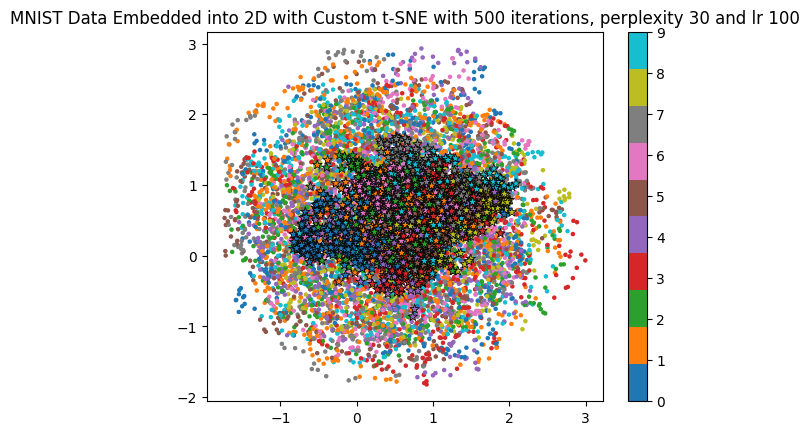

10 Closests train actual digits for each test digit


actual digit  1 closest digit  2 closest digit  3 closest digit  \
0              6                5                3                1   
1              2                5                9                1   
2              3                9                1                1   
3              7                1                2                4   
4              2                2                1                0   
5              2                5                1                2   
6              3                1                7                4   
7              4                3                5                7   
8              7                5                4                7   
9              6                3                0                8   
10             6                0                4                7   
11             9                5                7                9   
12             2                8                4                1   
13             0                4                9                2   
14             9                8                7                7   
15             6                4                8                7   
16             8                8                7                0   
17             0                1                8                0   
18             6                8                0                3   
19             5                6                7                8   
20             1                4                4                0   
21             4                3                6                9   
22             8                1                2                8   
23             1                8                9                0   
24             9                6                9                8   
25             8                2                1                6   
26             4                3                4                8   
27             0                0                6                8   
28             0                9                0                7   
29             5                8                2                7   
30             2                7                9                8   
31             4                2                2                1   
32             2                0                9                1   
33             1                9                0                1   
34             3                6                5                8   
35             2                8                9                6   
36             8                8                7                2   
37             1                3                6                1   
38             7                7                8                0   
39             6                9                1                6   
40             8                1                4                8   
41             2                8                8                6   
42             3                1                5                5   
43             3                6                4                0   
44             6                8                4                6   
45             1                6                3                6   
46             0                3                5                9   
47             4                2                7                8   
48             1                3                5                4   
49             0                7                9                7   

    4 closest digit  5 closest digit  6 closest digit  7 closest digit  \
0                 9                5                3                6   
1                 0                3                9                6   
2                 6                6                7                8   
3                 0                2                4                1   
4           

10 Closests train distances for each test oservability


actual digit  1 closest distance  2 closest distance  3 closest distance  \
0              6            0.008163            0.040237            0.042074   
1              2            0.020465            0.034019            0.038634   
2              3            0.019318            0.034596            0.036555   
3              7            0.034625            0.040117            0.044159   
4              2            0.023339            0.025960            0.031847   
5              2            0.017353            0.023095            0.041237   
6              3            0.015823            0.021633            0.027480   
7              4            0.020510            0.022696            0.039099   
8              7            0.006727            0.028152            0.034587   
9              6            0.029267            0.029414            0.032755   
10             6            0.009171            0.047280            0.047915   
11             9            0.004204            0.032112            0.032495   
12             2            0.012830            0.034460            0.040002   
13             0            0.018689            0.022022            0.043163   
14             9            0.006657            0.011642            0.020733   
15             6            0.015379            0.031594            0.033007   
16             8            0.025161            0.026485            0.029632   
17             0            0.009827            0.019128            0.028254   
18             6            0.016915            0.029057            0.035369   
19             5            0.005337            0.035461            0.037061   
20             1            0.019457            0.020096            0.021348   
21             4            0.007016            0.027004            0.030001   
22             8            0.010462            0.038100            0.038714   
23             1            0.012965            0.028965            0.041487   
24             9            0.003237            0.020992            0.027505   
25             8            0.020435            0.031602            0.036621   
26             4            0.009392            0.019881            0.027097   
27             0            0.018234            0.020461            0.025493   
28             0            0.011896            0.022824            0.028353   
29             5            0.036712            0.041407            0.047990   
30             2            0.027191            0.049307            0.070303   
31             4            0.014526            0.031592            0.035583   
32             2            0.026062            0.029355            0.031219   
33             1            0.026774            0.031549            0.032345   
34             3            0.035777            0.037485            0.046976   
35             2            0.019400            0.031257            0.040457   
36             8            0.022295            0.024279            0.024778   
37             1            0.016459            0.022483            0.023176   
38             7            0.003767            0.006366            0.015395   
39             6            0.014343            0.035569            0.044670   
40             8            0.014602            0.024690            0.034632   
41             2            0.008116            0.019099            0.032539   
42             3            0.025513            0.029674            0.039704   
43             3            0.026087            0.028393            0.028912   
44             6            0.007073            0.007909            0.023342   
45             1            0.014317            0.019950            0.026277   
46             0            0.032219            0.032817            0.043417   
47             4            0.019158            0.019904            0.030325   
48             1            0.027206            0.037600            0.042493   
49  

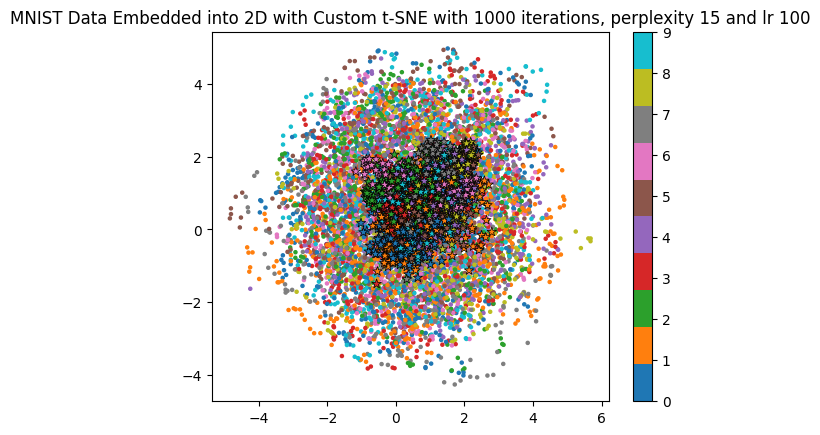

10 Closests train actual digits for each test digit


actual digit  1 closest digit  2 closest digit  3 closest digit  \
0              6                2                6                8   
1              2                9                1                5   
2              3                4                9                7   
3              7                5                9                7   
4              2                6                7                6   
5              2                5                1                7   
6              3                2                0                9   
7              4                7                2                1   
8              7                0                8                3   
9              6                6                2                6   
10             6                5                2                1   
11             9                8                7                2   
12             2                4                2                5   
13             0                6                3                9   
14             9                6                4                2   
15             6                0                8                5   
16             8                9                7                8   
17             0                1                6                8   
18             6                1                4                3   
19             5                9                0                2   
20             1                2                6                2   
21             4                6                6                4   
22             8                1                0                2   
23             1                6                2                2   
24             9                7                9                4   
25             8                6                5                5   
26             4                5                4                9   
27             0                2                8                4   
28             0                5                2                2   
29             5                2                1                7   
30             2                1                0                8   
31             4                6                5                9   
32             2                6                2                1   
33             1                2                5                3   
34             3                7                9                0   
35             2                5                5                3   
36             8                6                8                8   
37             1                7                8                8   
38             7                7                6                5   
39             6                5                5                4   
40             8                2                5                8   
41             2                0                6                5   
42             3                5                4                8   
43             3                7                7                5   
44             6                4                8                9   
45             1                7                5                3   
46             0                6                6                6   
47             4                6                6                6   
48             1                5                6                1   
49             0                0                0                6   

    4 closest digit  5 closest digit  6 closest digit  7 closest digit  \
0                 5                5                2                1   
1                 8                6                6                1   
2                 1                6                4                3   
3                 2                2                2                9   
4           

10 Closests train distances for each test oservability


actual digit  1 closest distance  2 closest distance  3 closest distance  \
0              6            0.037022            0.055053            0.070784   
1              2            0.023538            0.038670            0.044798   
2              3            0.024886            0.027060            0.062535   
3              7            0.001986            0.019464            0.028447   
4              2            0.088811            0.101966            0.113650   
5              2            0.025984            0.060848            0.064364   
6              3            0.025739            0.037764            0.040159   
7              4            0.030910            0.033899            0.064994   
8              7            0.031270            0.037987            0.040148   
9              6            0.026417            0.041311            0.071547   
10             6            0.033133            0.037504            0.039697   
11             9            0.032849            0.034044            0.036752   
12             2            0.050814            0.058422            0.063014   
13             0            0.031546            0.047096            0.052805   
14             9            0.069307            0.076322            0.080250   
15             6            0.055879            0.056185            0.057796   
16             8            0.041224            0.048291            0.066229   
17             0            0.012165            0.042443            0.047987   
18             6            0.027421            0.036936            0.036956   
19             5            0.025958            0.064178            0.074124   
20             1            0.067925            0.071266            0.087908   
21             4            0.029979            0.030200            0.049692   
22             8            0.013820            0.028661            0.031506   
23             1            0.036225            0.037339            0.039081   
24             9            0.016809            0.037737            0.038676   
25             8            0.039962            0.053436            0.068526   
26             4            0.058045            0.068448            0.069161   
27             0            0.022612            0.036830            0.040349   
28             0            0.011792            0.036282            0.042127   
29             5            0.017975            0.024824            0.027113   
30             2            0.026155            0.049375            0.050835   
31             4            0.012931            0.031550            0.046159   
32             2            0.021024            0.064863            0.076040   
33             1            0.033460            0.041173            0.059992   
34             3            0.022800            0.038201            0.050273   
35             2            0.007774            0.016921            0.018335   
36             8            0.023400            0.042751            0.053171   
37             1            0.044358            0.057598            0.061370   
38             7            0.033491            0.041249            0.054355   
39             6            0.030261            0.066999            0.078044   
40             8            0.031760            0.032903            0.035161   
41             2            0.019190            0.037953            0.044840   
42             3            0.022241            0.029021            0.049755   
43             3            0.008915            0.039763            0.056322   
44             6            0.031821            0.052771            0.068538   
45             1            0.060175            0.081834            0.085261   
46             0            0.029125            0.034247            0.048383   
47             4            0.028161            0.047064            0.050611   
48             1            0.012326            0.027143            0.053151   
49  

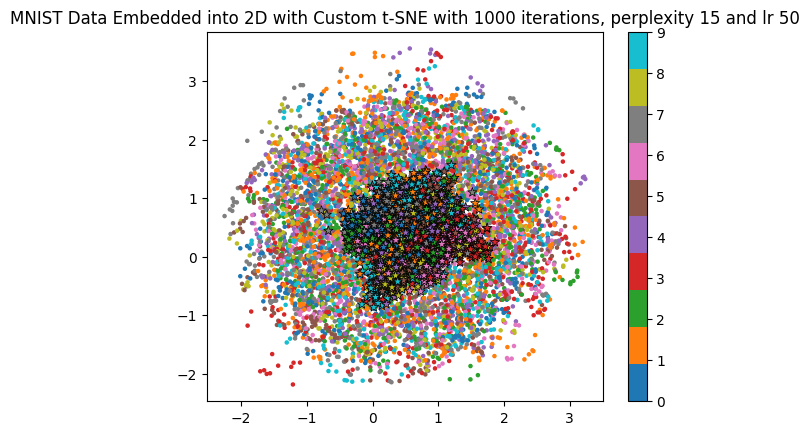

10 Closests train actual digits for each test digit


actual digit  1 closest digit  2 closest digit  3 closest digit  \
0              6                1                7                2   
1              2                3                9                5   
2              3                6                7                1   
3              7                2                1                9   
4              2                9                7                6   
5              2                0                1                8   
6              3                4                4                2   
7              4                7                5                4   
8              7                8                6                8   
9              6                8                2                2   
10             6                2                7                5   
11             9                7                9                8   
12             2                8                8                0   
13             0                9                2                4   
14             9                1                1                1   
15             6                4                3                2   
16             8                9                4                9   
17             0                0                3                7   
18             6                9                1                3   
19             5                4                6                0   
20             1                4                4                6   
21             4                8                5                7   
22             8                9                8                4   
23             1                0                2                9   
24             9                1                4                7   
25             8                3                0                3   
26             4                3                9                7   
27             0                1                6                4   
28             0                1                7                4   
29             5                7                2                9   
30             2                6                5                9   
31             4                0                0                6   
32             2                9                2                8   
33             1                0                3                3   
34             3                2                4                5   
35             2                8                9                7   
36             8                4                0                8   
37             1                7                6                2   
38             7                9                8                7   
39             6                1                7                8   
40             8                8                5                4   
41             2                2                9                9   
42             3                4                8                2   
43             3                8                8                4   
44             6                1                9                6   
45             1                7                9                7   
46             0                8                8                2   
47             4                3                3                7   
48             1                6                1                5   
49             0                7                7                2   

    4 closest digit  5 closest digit  6 closest digit  7 closest digit  \
0                 3                8                3                7   
1                 4                6                8                7   
2                 2                2                7                5   
3                 1                8                4                6   
4           

10 Closests train distances for each test oservability


actual digit  1 closest distance  2 closest distance  3 closest distance  \
0              6            0.022837            0.034638            0.045624   
1              2            0.040223            0.048988            0.053818   
2              3            0.012064            0.018930            0.020947   
3              7            0.013857            0.022110            0.024105   
4              2            0.030713            0.037715            0.043406   
5              2            0.050483            0.051373            0.054050   
6              3            0.021966            0.022437            0.033421   
7              4            0.032759            0.042061            0.052761   
8              7            0.007646            0.025099            0.029751   
9              6            0.029468            0.032939            0.033346   
10             6            0.019375            0.027789            0.028140   
11             9            0.023184            0.040136            0.044479   
12             2            0.012758            0.020847            0.030002   
13             0            0.030681            0.033743            0.039488   
14             9            0.027700            0.047843            0.054197   
15             6            0.032909            0.043954            0.045313   
16             8            0.034313            0.035508            0.039477   
17             0            0.025198            0.030787            0.034583   
18             6            0.025542            0.033739            0.037638   
19             5            0.019223            0.039970            0.045063   
20             1            0.030740            0.038057            0.047586   
21             4            0.021798            0.022846            0.030203   
22             8            0.025407            0.028360            0.030507   
23             1            0.008231            0.034373            0.035531   
24             9            0.014176            0.038975            0.040614   
25             8            0.041315            0.042358            0.053758   
26             4            0.009706            0.020482            0.030253   
27             0            0.043114            0.043855            0.045470   
28             0            0.012592            0.016049            0.045462   
29             5            0.042914            0.044560            0.052458   
30             2            0.012760            0.023390            0.036890   
31             4            0.002539            0.007408            0.044971   
32             2            0.023719            0.025592            0.032206   
33             1            0.020771            0.023908            0.032471   
34             3            0.015218            0.025986            0.036645   
35             2            0.003129            0.003487            0.012139   
36             8            0.011918            0.027523            0.040050   
37             1            0.017236            0.035019            0.037131   
38             7            0.041182            0.042344            0.043473   
39             6            0.007245            0.024262            0.050430   
40             8            0.028474            0.031844            0.037770   
41             2            0.019080            0.022277            0.023902   
42             3            0.014988            0.024243            0.049777   
43             3            0.029263            0.039176            0.053161   
44             6            0.019435            0.038891            0.042293   
45             1            0.039550            0.052041            0.055750   
46             0            0.019591            0.021893            0.027226   
47             4            0.006130            0.010279            0.030620   
48             1            0.024663            0.026208            0.042353   
49  

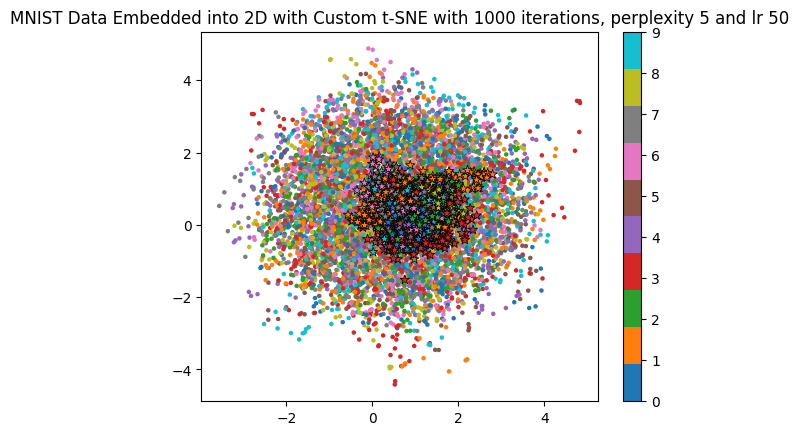

10 Closests train actual digits for each test digit


actual digit  1 closest digit  2 closest digit  3 closest digit  \
0              6                0                7                8   
1              2                2                9                6   
2              3                6                1                7   
3              7                4                8                1   
4              2                3                4                9   
5              2                8                3                6   
6              3                7                5                1   
7              4                2                5                2   
8              7                5                6                8   
9              6                1                8                8   
10             6                2                8                0   
11             9                4                5                1   
12             2                4                8                2   
13             0                5                6                2   
14             9                2                9                2   
15             6                9                8                7   
16             8                3                0                3   
17             0                7                4                9   
18             6                1                9                8   
19             5                8                8                3   
20             1                3                5                7   
21             4                8                6                1   
22             8                0                3                5   
23             1                3                0                9   
24             9                6                9                2   
25             8                8                6                7   
26             4                9                5                2   
27             0                8                3                6   
28             0                7                8                1   
29             5                2                5                7   
30             2                8                6                5   
31             4                9                1                1   
32             2                9                4                7   
33             1                6                1                8   
34             3                4                7                6   
35             2                0                1                3   
36             8                1                9                5   
37             1                1                8                0   
38             7                7                9                5   
39             6                4                6                0   
40             8                1                6                9   
41             2                0                1                7   
42             3                9                4                6   
43             3                7                9                7   
44             6                7                6                2   
45             1                1                7                2   
46             0                6                1                4   
47             4                9                8                4   
48             1                6                5                1   
49             0                9                4                4   

    4 closest digit  5 closest digit  6 closest digit  7 closest digit  \
0                 1                3                0                9   
1                 9                0                4                4   
2                 4                4                5                9   
3                 6                1                8                3   
4           

10 Closests train distances for each test oservability


actual digit  1 closest distance  2 closest distance  3 closest distance  \
0              6            0.017506            0.040653            0.045458   
1              2            0.013422            0.021531            0.042742   
2              3            0.028222            0.036414            0.055468   
3              7            0.029237            0.038317            0.042319   
4              2            0.015605            0.035934            0.042453   
5              2            0.048286            0.062453            0.069141   
6              3            0.006005            0.022722            0.037546   
7              4            0.025685            0.051763            0.071920   
8              7            0.023541            0.024905            0.028123   
9              6            0.022259            0.027932            0.034330   
10             6            0.042520            0.046079            0.046523   
11             9            0.019001            0.040877            0.052576   
12             2            0.026993            0.029001            0.037343   
13             0            0.008458            0.027371            0.040265   
14             9            0.018616            0.033520            0.045700   
15             6            0.004220            0.013498            0.030697   
16             8            0.014053            0.021105            0.033267   
17             0            0.031977            0.054603            0.060821   
18             6            0.029628            0.037883            0.038511   
19             5            0.012048            0.013563            0.014761   
20             1            0.036395            0.056666            0.064568   
21             4            0.011512            0.014583            0.038535   
22             8            0.028392            0.048608            0.051047   
23             1            0.044099            0.049538            0.063856   
24             9            0.037232            0.048297            0.057114   
25             8            0.015901            0.023491            0.028681   
26             4            0.040867            0.051886            0.053181   
27             0            0.034301            0.073114            0.081207   
28             0            0.034295            0.042491            0.043638   
29             5            0.029534            0.062152            0.063931   
30             2            0.005439            0.012494            0.037029   
31             4            0.021506            0.021895            0.022177   
32             2            0.025835            0.053880            0.059046   
33             1            0.020469            0.052391            0.073104   
34             3            0.041167            0.055064            0.064319   
35             2            0.010383            0.019097            0.030489   
36             8            0.007480            0.057094            0.059647   
37             1            0.022952            0.023148            0.028702   
38             7            0.029506            0.053877            0.057547   
39             6            0.015575            0.028256            0.042171   
40             8            0.043823            0.062908            0.063415   
41             2            0.034952            0.045662            0.049778   
42             3            0.024876            0.028241            0.043851   
43             3            0.017371            0.030698            0.035180   
44             6            0.043199            0.061367            0.062794   
45             1            0.046077            0.050622            0.054954   
46             0            0.032272            0.045445            0.058508   
47             4            0.016481            0.035071            0.052329   
48             1            0.006228            0.038511            0.040711   
49  

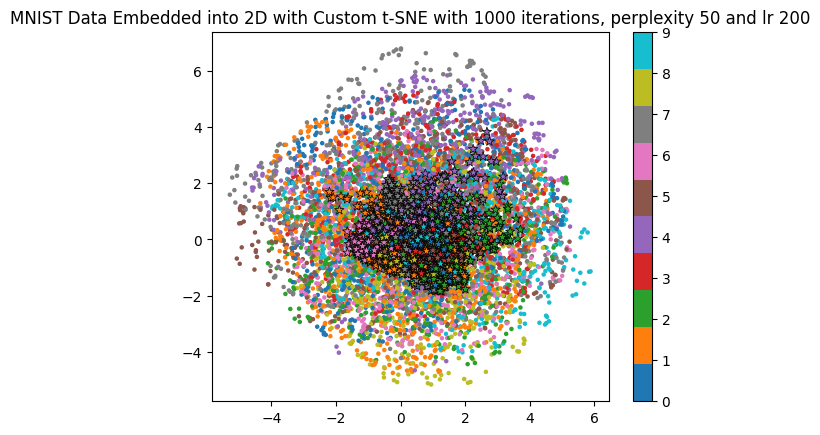

10 Closests train actual digits for each test digit


actual digit  1 closest digit  2 closest digit  3 closest digit  \
0              6                7                7                7   
1              2                6                6                8   
2              3                3                6                8   
3              7                9                0                3   
4              2                9                7                0   
5              2                3                8                8   
6              3                0                0                9   
7              4                0                0                6   
8              7                7                5                5   
9              6                9                4                4   
10             6                4                0                2   
11             9                0                4                2   
12             2                6                0                9   
13             0                3                0                3   
14             9                7                9                8   
15             6                0                3                8   
16             8                1                0                8   
17             0                0                3                0   
18             6                7                3                6   
19             5                1                1                2   
20             1                7                6                1   
21             4                8                9                7   
22             8                9                2                3   
23             1                4                3                1   
24             9                0                5                7   
25             8                4                0                6   
26             4                7                9                3   
27             0                3                2                1   
28             0                3                4                6   
29             5                0                1                0   
30             2                5                9                1   
31             4                6                2                4   
32             2                8                2                5   
33             1                9                1                5   
34             3                1                9                3   
35             2                8                6                8   
36             8                4                0                0   
37             1                1                3                0   
38             7                7                9                6   
39             6                0                5                3   
40             8                1                5                1   
41             2                8                8                8   
42             3                3                3                4   
43             3                5                3                1   
44             6                9                7                8   
45             1                1                8                9   
46             0                3                3                3   
47             4                9                5                2   
48             1                9                2                0   
49             0                1                0                6   

    4 closest digit  5 closest digit  6 closest digit  7 closest digit  \
0                 9                0                1                4   
1                 2                6                4                3   
2                 2                9                6                9   
3                 2                1                1                1   
4           

10 Closests train distances for each test oservability


actual digit  1 closest distance  2 closest distance  3 closest distance  \
0              6            0.021907            0.028035            0.034267   
1              2            0.052130            0.086930            0.102600   
2              3            0.042968            0.062643            0.092392   
3              7            0.038034            0.053939            0.056305   
4              2            0.006973            0.097075            0.115921   
5              2            0.024522            0.059561            0.060208   
6              3            0.010656            0.029755            0.053812   
7              4            0.036580            0.064098            0.073048   
8              7            0.019733            0.076006            0.079386   
9              6            0.030647            0.052248            0.063344   
10             6            0.059255            0.069242            0.091329   
11             9            0.022708            0.027813            0.031672   
12             2            0.069723            0.072362            0.098905   
13             0            0.005995            0.063698            0.070424   
14             9            0.033421            0.050009            0.056924   
15             6            0.041541            0.051915            0.065762   
16             8            0.041989            0.047058            0.058980   
17             0            0.065315            0.074001            0.076688   
18             6            0.030982            0.044301            0.047109   
19             5            0.031408            0.052199            0.054396   
20             1            0.010422            0.024054            0.050106   
21             4            0.064238            0.071328            0.071775   
22             8            0.043206            0.072361            0.077706   
23             1            0.036685            0.076882            0.086652   
24             9            0.016689            0.027902            0.035194   
25             8            0.049704            0.060120            0.061422   
26             4            0.015034            0.042329            0.053580   
27             0            0.038774            0.089420            0.103906   
28             0            0.050268            0.051395            0.064506   
29             5            0.081891            0.085908            0.113887   
30             2            0.028955            0.036718            0.075820   
31             4            0.025270            0.028082            0.033395   
32             2            0.046187            0.050981            0.058931   
33             1            0.019904            0.067333            0.084829   
34             3            0.055478            0.057524            0.074174   
35             2            0.033491            0.037847            0.048760   
36             8            0.019635            0.079949            0.081692   
37             1            0.062106            0.068044            0.071410   
38             7            0.047885            0.056313            0.065793   
39             6            0.040164            0.058244            0.060709   
40             8            0.068489            0.080539            0.090471   
41             2            0.039832            0.058290            0.058320   
42             3            0.081677            0.087930            0.091490   
43             3            0.009946            0.070713            0.070775   
44             6            0.068388            0.088757            0.091105   
45             1            0.025498            0.040385            0.054891   
46             0            0.033325            0.065844            0.069219   
47             4            0.016236            0.052649            0.061350   
48             1            0.022108            0.058384            0.072359   
49  

In [61]:
from IPython.display import display

for idx, result in enumerate(results_array):
    # Transform new data
    custom_Y_new = custom_tsne.transform(X_train_normalized_opt1,result["custom_Y"],X_test)
    
    if result["custom_Y"].shape[1] == 2:
        # Visualization of the result
        plt.figure()
        plt.scatter(result["custom_Y"][:, 0], result["custom_Y"][:, 1], s=5, c=label_train.astype(int), cmap='tab10')
        plt.scatter(custom_Y_new[:, 0], custom_Y_new[:, 1], marker = '*', s=50, linewidths=0.5, edgecolors='k', c=label_test.astype(int), cmap='tab10')
        plt.colorbar()
        plt.title(f"MNIST Data Embedded into 2D with Custom t-SNE with {hypher_pharams_options[idx]['n_iter']} iterations, perplexity {hypher_pharams_options[idx]['perplexity']} and lr {hypher_pharams_options[idx]['learning_rate']}")
        plt.show()

        # Top 10 nearest neighbor of each test set
        dists = cdist(custom_Y_new, result["custom_Y"])
        n_nearest_digits = label_train[np.argsort(dists, axis=1)[:, :10]]
        n_nearest_distances = np.sort(dists, axis=1)[:, :10]

        df1 = pd.DataFrame(label_test, columns = ["actual digit"])
        df2 = pd.DataFrame(n_nearest_digits, columns = [f"{idx+1} closest digit" for idx in range(n_nearest_digits.shape[1])])
        df3 = pd.DataFrame(n_nearest_distances, columns = [f"{idx+1} closest distance" for idx in range(n_nearest_distances.shape[1])])
        df_digits = df1.join(df2)
        df_distances = df1.join(df3)

        print("10 Closests train actual digits for each test digit")
        display(df_digits[:50])
        print("10 Closests train distances for each test oservability")
        display(df_distances[:50])

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment. 

We used ChatGPT to help us utilize numpy vectorised functions more effieintly. It also proposed subtracting the maximum when calculating exponents, in order to avoid very large/small values.